In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import holidays

In [2]:
# Price Data
price_Easy = 'C:/Users/Diego Galdino/OneDrive - Groene Cadans B.V/Algorithms/Energy-Price-Easy/EasyEnergyPrice.csv'
price_Entosoe = 'C:/Users/Diego Galdino/OneDrive - Groene Cadans B.V/Algorithms/Energy-Price-ENTSOE/EntsoeEnergyPrice.csv'

In [3]:
while True:
    # Select price source
    price_source = input("Select the price source:\n1 - Easy\n2 - Entsoe\n")

    # Read price data based on the selected source
    if price_source == "1":
        df_price = pd.read_csv(price_Easy)
        break
    elif price_source == "2":
        df_price = pd.read_csv(price_Entosoe)
        break
    else:
        print("Invalid selection. Try again.")

Select the price source:
1 - Easy
2 - Entsoe
2


In [4]:
# Copy the DataFrame with price data
df = df_price.copy()

# Convert the "Date" column to a date object
df['Date'] = pd.to_datetime(df['Date'])

# Extract the hour from the "Hour" column
df['Hour'] = pd.to_datetime(df['Hour']).dt.time

# Fill missing values with zero
df['Import Grid (EUR/kWh)'] = df['Import Grid (EUR/kWh)'].fillna(0)
df['Export Grid (EUR/kWh)'] = df['Export Grid (EUR/kWh)'].fillna(0)

# Sum the "Import Grid (EUR/kWh)" and "Export Grid (EUR/kWh)" columns
df['Price (EUR/kWh)'] = df['Import Grid (EUR/kWh)'] + df['Export Grid (EUR/kWh)']

df.head()

C:\Users\Diego Galdino\AppData\Local\Temp\ipykernel_15312\4104255178.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Hour']).dt.time


,Date,Hour,Import Grid (EUR/kWh),Export Grid (EUR/kWh),Price (EUR/kWh)
0,2023-05-25,23:00:00,0.09094,0.0,0.09094
1,2023-05-25,22:00:00,0.10047,0.0,0.10047
2,2023-05-25,21:00:00,0.10713,0.0,0.10713
3,2023-05-25,20:00:00,0.12171,0.0,0.12171
4,2023-05-25,19:00:00,0.10711,0.0,0.10711


In [5]:
# Find the minimum date in the dataset
min_date = df['Date'].min()

# Filter the dataframe for the minimum date
min_day_df = df[df['Date'] == min_date]

# Identify the first hour of significant increase in energy price for the smallest day
threshold = (min_day_df['Price (EUR/kWh)'].max() -  min_day_df['Price (EUR/kWh)'].min())/4 # Define a threshold value to consider a significant increase in price
increased_prices = min_day_df[min_day_df['Price (EUR/kWh)'].diff() > threshold]
if not increased_prices.empty:
    first_peak_hour = increased_prices['Hour'].iloc[0]
    print(f"The first hour of significant increase in energy price for the smallest day is {first_peak_hour}.")
else:
    print("No significant increase in energy price found for the smallest day.")


The first hour of significant increase in energy price for the smallest day is 07:00:00.


In [6]:
threshold

0.0024025

In [7]:
# Find the highest and lowest prices for the smallest day
max_price = min_day_df['Price (EUR/kWh)'].max()
min_price = min_day_df['Price (EUR/kWh)'].min()

# Display the highest and lowest prices
print(f"The highest price for the smallest day is {max_price} EUR/kWh.")
print(f"The lowest price for the smallest day is {min_price} EUR/kWh.")

The highest price for the smallest day is 0.03143 EUR/kWh.
The lowest price for the smallest day is 0.02182 EUR/kWh.


C:\Users\Diego Galdino\AppData\Local\Temp\ipykernel_15312\193685824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_day_df['Hour'] = min_day_df['Hour'].astype(str)


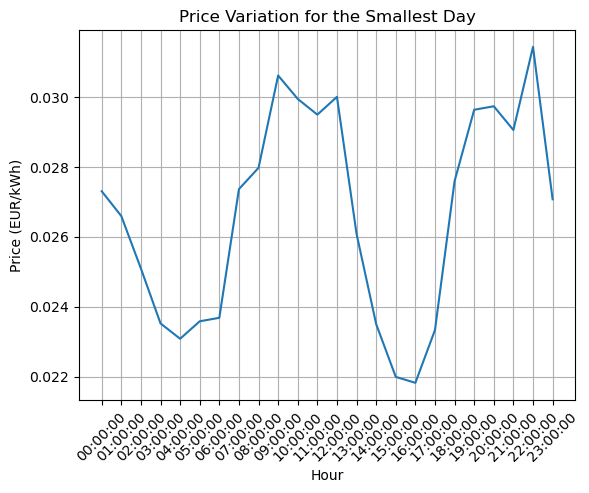

In [8]:
# Convert the 'Hour' column to string
min_day_df['Hour'] = min_day_df['Hour'].astype(str)

# Extract the price and hour columns
prices = min_day_df['Price (EUR/kWh)']
hours = min_day_df['Hour']

# Plot the price variation
plt.plot(hours, prices)
plt.xlabel('Hour')
plt.ylabel('Price (EUR/kWh)')
plt.title('Price Variation for the Smallest Day')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

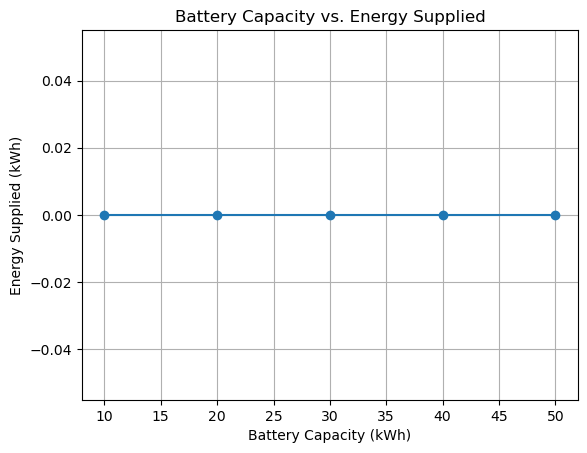

In [10]:
# Function to calculate recharge and discharge time based on battery capacity and charging rate
def calculate_time(capacity, rate):
    recharge_time = round(capacity / rate)
    discharge_time = recharge_time
    return recharge_time, discharge_time

# Function to simulate battery usage and calculate energy supplied
def simulate_battery_usage(df, capacity, rate):
    df = df.reset_index(drop=True)  # Reset index
    hours = df['Hour']
    prices = df['Price (EUR/kWh)']
    energy_supplied = 0

    # Calculate recharge and discharge time
    recharge_time, discharge_time = calculate_time(capacity, rate)

    # Iterate over the hours
    for i in range(len(hours)):
        # Check if the battery needs to be recharged or discharged
        if energy_supplied <= 0:
            # Recharge the battery during negative peak periods
            if prices[i] < 0:
                energy_supplied += capacity
                if energy_supplied > 0:
                    energy_supplied = 0
        else:
            # Discharge the battery during positive peak periods
            if prices[i] > 0:
                energy_supplied -= capacity

        # Apply recharge and discharge time
        if energy_supplied < 0:
            energy_supplied = min(energy_supplied, -rate * discharge_time)
        else:
            energy_supplied = max(energy_supplied, -rate * recharge_time)

    return energy_supplied

# Analyze the smallest day in the dataset
min_day = df['Date'].value_counts().idxmin()
min_day_df = df[df['Date'] == min_day]

# Identify the first hour of significant increase in energy price
significant_increase = min_day_df['Price (EUR/kWh)'].diff() > threshold
if significant_increase.any():
    first_peak_hour = min_day_df[significant_increase]['Hour'].iloc[0]
    # Specify the battery capacity
    battery_capacity = 20  # Modify the capacity as needed
    # Specify the charging rate
    charging_rate = 5  # Modify the charging rate as needed
    # Calculate the recharge and discharge time for the current battery size
    recharge_time, discharge_time = calculate_time(battery_capacity, charging_rate)
else:
    # If no significant increase, set first_peak_hour, recharge_time, and discharge_time to None
    first_peak_hour = None
    recharge_time = None
    discharge_time = None

# Simulate battery usage for different battery capacities and plot the results
capacities = [10, 20, 30, 40, 50]  # Battery capacities in kWh
energy_supplied_list = []

for capacity in capacities:
    energy_supplied = simulate_battery_usage(min_day_df, capacity, charging_rate)
    energy_supplied_list.append(energy_supplied)

# Plot the results
plt.plot(capacities, energy_supplied_list, marker='o')
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('Energy Supplied (kWh)')
plt.title('Battery Capacity vs. Energy Supplied')
plt.grid(True)
plt.show()